In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

In [2]:
# Login
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('PRIYAPATEL0513@GMAIL.COM', '4uvRjWXe5b')

if not status:
    print(msg)
else:
    print('You are logged in!')

You are logged in!


In [3]:
def get_formatted_dataframe(xls_file, year):
    df = pd.read_excel(xls_file)
    df = df[['DZRATING', 'DZCAMPUS','DPETALLC','DA0AT' + str(year) + 'R', 'DA0912DR' + str(year) + 'R','DAGC4X' + str(year) + 'R','DAGC5X' + str(year - 1) + 'R','DA0GR' + str(year) + 'N','DA0CT' + str(year) + 'R','DA0CC' + str(year) + 'R','DA0CSA' + str(year) + 'R','DA0CAA' + str(year) + 'R','DPSTTOSA','DPSTEXPA','DPFRAALLT','DPFRAALLK','DPFRASTAP','DZRVLOCP','DPFRAFEDP','DPFEAINST','DPFEAINSK','DISTSIZE','COMMTYPE', 'PROPWLTH', 'TAXRATE']]
    df = df.rename(index=str, columns = {"DZRATING":"rating", "DZCAMPUS":"num_schools", "DPETALLC":"num_students", "DA0AT" + str(year) + "R":"attendance_rate", "DA0912DR" + str(year) + "R":"dropout_rate", "DAGC4X" + str(year) + "R":"grad_rate_4_year", "DAGC5X" + str(year - 1) + "R":"grad_rate_5_year", "DA0GR" + str(year) + "N":"annual_grad_count", "DA0CT" + str(year) + "R":"college_admissions_per_tested", "DA0CC" + str(year) + "R":"college_admissions_at_crit", "DA0CSA" + str(year) + "R":"average_sat", "DA0CAA" + str(year) + "R":"average_act", "DPSTTOSA":"average_teacher_salary", "DPSTEXPA":"average_teacher_exp", "DPFRAALLT":"total_revenue", "DPFRAALLK":"total_revenue_per_pupil", "DPFRASTAP":"percent_revenue_from_state", "DZRVLOCP":"percent_revenue_from_local", "DPFRAFEDP":"percent_revenue_from_federal", "DPFEAINST":"instr_expenditures", "DPFEAINSK":"instr_expenditures_per_pupil", "DISTSIZE":"district_size", "COMMTYPE":"community_type", "PROPWLTH":"property_wealth", "TAXRATE":"tax_rate"})
    return df

In [4]:
test_df = get_formatted_dataframe('2016-2017.xls', 16)
train_df = get_formatted_dataframe('2015-2016.xls',15)
train_df = train_df.append(get_formatted_dataframe('2014-2015.xls',14))
train_df = train_df.append(get_formatted_dataframe('2013-2014.xls',13))
print('Test dataframe shape:', test_df.shape)
print('Train dataframe shape:', train_df.shape)

Test dataframe shape: (1203, 25)
Train dataframe shape: (3653, 25)


In [5]:
def clean_dataframe(df):
    df = df.loc[(df['rating'] == "Met Standard") | (df['rating'] == "Met Alternative Standard") |(df['rating'] == "Improvement Required")]
    features = list(df)[3:21]
    for feature in features:
        df = df.loc[(df[feature] != '.')]
    df = df.dropna()
    return df

In [6]:
# Cleaning the data
train_df = clean_dataframe(train_df)
test_df = clean_dataframe(test_df)
print('After cleaning:')
print('Test dataframe shape:', test_df.shape)
print('Train dataframe shape:', train_df.shape)

After cleaning:
Test dataframe shape: (908, 25)
Train dataframe shape: (2749, 25)


In [7]:
# Dealing with class imbalance
labels = list(train_df)[1:]

print("Before oversampling:")
print(train_df['rating'].value_counts())
print()

from imblearn.over_sampling import SMOTENC
ad = SMOTENC(categorical_features=[20, 21, 22, 23], random_state=None)
train_df_y = train_df['rating']
train_df_x = train_df.iloc[:,1:]
x_res, y_res = ad.fit_sample(train_df_x, train_df_y)

train_df = pd.DataFrame(data=x_res, columns=labels)
train_df['rating'] = y_res

print("After oversampling:")
print(train_df['rating'].value_counts())

Before oversampling:
Met Standard                2589
Improvement Required         107
Met Alternative Standard      53
Name: rating, dtype: int64

After oversampling:
Improvement Required        2589
Met Alternative Standard    2589
Met Standard                2589
Name: rating, dtype: int64


In [8]:
test_df.to_csv('test_data.csv')
train_df.to_csv('train_data.csv')

In [9]:
TRAIN_DATASET = 'train_data.csv'
TEST_DATASET = 'test_data.csv'
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
status, message = ds.delete_dataset(TRAIN_DATASET)
status, dataset = ds.upload_dataset(TRAIN_DATASET)
if not status:
    print(dataset)
status, message = ds.delete_dataset(TEST_DATASET)
status, dataset = ds.upload_dataset(TEST_DATASET)
if not status:
    print(dataset)

In [10]:
#clean train_Set
target = "rating"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T19:57:57.565226', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['5b3fd892c9ac4550bcce87f67fddd867'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T19:57:57.565226', 'endtime': '2019-04-22T19:58:02.070841', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['5b3fd892c9ac4550bcce87f67fddd867'], 'model_name': None, 'job_error': ''}


In [11]:
model = target + "_model01" + ts
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T19:58:13.812041', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190422195745', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T19:58:13.812041', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190422195745', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T19:58:13.812041', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190422195745', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T19:58:13.812041', 'endtime': None, 'percent_complete': 7, 'j

In [12]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Running', 'starttime': '2019-04-22T20:00:30.549379', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': None, 'artifact_names': ['0ce67e499e7d4f969c851c5b3a95a52c'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T20:00:30.549379', 'endtime': '2019-04-22T20:00:32.395636', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': None, 'artifact_names': ['0ce67e499e7d4f969c851c5b3a95a52c'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}


In [13]:
feature_importance[:10]

Unnamed: 0                        0.411665
percent_revenue_from_local        0.079952
percent_revenue_from_state        0.066376
college_admissions_per_tested     0.059296
tax_rate = Non-taxing entities    0.049979
grad_rate_5_year                  0.038044
average_teacher_exp               0.036198
attendance_rate                   0.026928
grad_rate_4_year                  0.026592
average_sat                       0.026339
dtype: float64

In [14]:
status, artifact = ds.run_model(TRAIN_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-22T20:00:48.278042', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['train_data.csv'], 'artifact_names': ['fe5741d3d60c45499c13bab6dcba951e'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T20:00:48.278042', 'endtime': '2019-04-22T20:00:49.377437', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['train_data.csv'], 'artifact_names': ['fe5741d3d60c45499c13bab6dcba951e'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}


(True, 'Job completed')

In [15]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,prob_Improvement Required,prob_Met Alternative Standard,prob_Met Standard,rating
0,0.000563,6.530000e-08,0.999437,Met Standard
1,0.000038,1.824000e-07,0.999962,Met Standard
2,0.000728,1.523200e-06,0.999270,Met Standard
3,0.000222,1.597000e-05,0.999762,Met Standard
4,0.000191,8.589000e-07,0.999808,Met Standard


                          precision    recall  f1-score   support

    Improvement Required       0.99      0.98      0.99      2589
Met Alternative Standard       1.00      1.00      1.00      2589
            Met Standard       0.98      0.99      0.99      2589

               micro avg       0.99      0.99      0.99      7767
               macro avg       0.99      0.99      0.99      7767
            weighted avg       0.99      0.99      0.99      7767



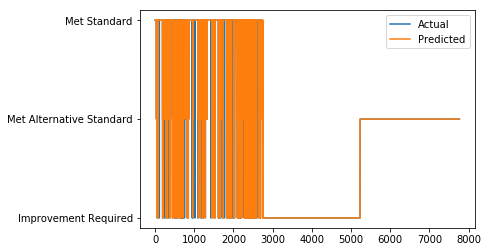

In [16]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(train_df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(train_df[target], prediction[target]))

In [17]:
#TEST DATASET
status, message = ds.delete_dataset(TEST_DATASET)
status, dataset = ds.upload_dataset( TEST_DATASET)
if not status:
    print(dataset)

In [18]:
status, job_id = ds.clean_data(TEST_DATASET, target = target, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T20:01:07.625087', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['d98eb5e140d4431b824479b690cf2758'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T20:01:07.625087', 'endtime': '2019-04-22T20:01:12.575187', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['d98eb5e140d4431b824479b690cf2758'], 'model_name': None, 'job_error': ''}


In [19]:
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-22T20:01:23.865418', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['test_data.csv'], 'artifact_names': ['932275e83fb54d3d941b819fe99abcfe'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T20:01:23.865418', 'endtime': '2019-04-22T20:01:25.089764', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.5947907567024231, 'generations': 2, 'dataset_names': ['test_data.csv'], 'artifact_names': ['932275e83fb54d3d941b819fe99abcfe'], 'model_name': 'rating_model0120190422195745', 'job_error': ''}


(True, 'Job completed')

                          precision    recall  f1-score   support

    Improvement Required       0.00      0.00      0.00        19
Met Alternative Standard       0.79      0.83      0.81        18
            Met Standard       0.98      1.00      0.99       871

               micro avg       0.97      0.97      0.97       908
               macro avg       0.59      0.61      0.60       908
            weighted avg       0.95      0.97      0.96       908



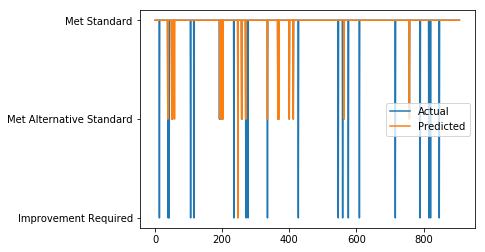

In [20]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(TEST_DATASET)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))